/Users/scottliyq/opt/miniconda3/envs/py310btc/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
2022-10-28 15:12:03,890 - INFO - start load files...


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


2022-10-28 15:12:04,135 - INFO - load file complete, preparing...
2022-10-28 15:12:06,437 - INFO - data has benn prepared
2022-10-28 15:12:06,546 - INFO - init strategy...
2022-10-28 15:12:07,594 - INFO - start main loop...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7199/7199 [00:08<00:00, 876.46it/s]
2022-10-28 15:12:15,939 - INFO - main loop finished, start calculate evaluating indicator...
2022-10-28 15:12:15,965 - INFO - run evaluating indicator
2022-10-28 15:12:15,969 - INFO - back testing finish


2007.0649usdc


/Users/scottliyq/go/hardhat_space/demeter/working/strategy_ploter.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


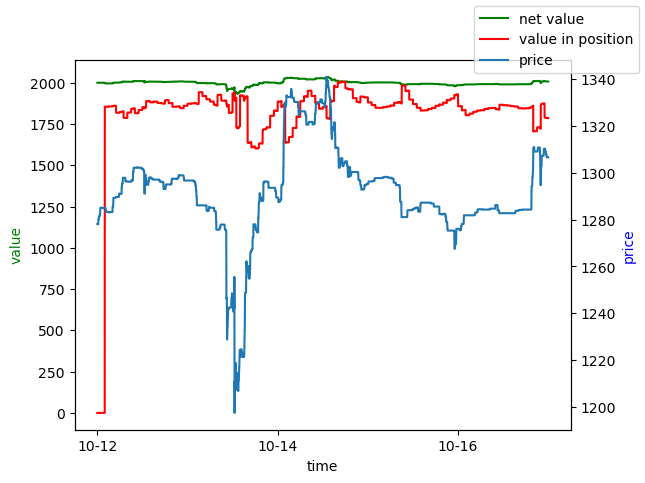

In [1]:
from datetime import date, datetime
from typing import Union
import demeter.indicator
from demeter import TokenInfo, PoolBaseInfo, Runner, Strategy, Asset, AccountStatus, BuyAction, SellAction, RowData, \
    ChainType
import pandas as pd
from strategy_ploter import plotter, plot_position_return_decomposition

%matplotlib inline

%pylab inline

class AddLpByMa(Strategy):
    price_width = None

    def __init__(self, price_width=100):
        super().__init__()
        self.price_width = price_width

    def initialize(self):

        prices = self.data.closeTick.map(lambda x: self.broker.tick_to_price(x))
        self._add_column("ma5", demeter.indicator.simple_moving_average(prices, 5))

    def rebalance(self, price):
        status: AccountStatus = self.broker.get_account_status(price)
        base_amount = status.net_value / 2
        quote_amount_diff = base_amount / price - status.quote_balance
        if quote_amount_diff > 0:
            self.buy(quote_amount_diff)
        elif quote_amount_diff < 0:
            self.sell(0 - quote_amount_diff)

    def next(self, row_data: Union[RowData, pd.Series]):
        if row_data.timestamp.minute != 0:
            return
        # print(self.broker.base_asset.balance)
        if len(self.broker.positions) > 0:
            keys = list(self.broker.positions.keys())
            for k in keys:
                self.remove_liquidity(k)
            self.rebalance(row_data.price)
        ma_price = row_data.ma5 if row_data.ma5 > 0 else row_data.price
        self.add_liquidity(ma_price - self.price_width,
                           ma_price + self.price_width)

    def notify_buy(self, action: BuyAction):
        print(action.get_output_str(), action.base_balance_after / action.quote_balance_after)

    def notify_sell(self, action: SellAction):
        print(action.get_output_str(), action.base_balance_after / action.quote_balance_after)


if __name__ == "__main__":
    pd.options.plotting.backend = "plotly"

    pool_id_tie500 = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'

    pool_id_tie3000 = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
    
    eth = TokenInfo(name="eth", decimal=18)
    usdc = TokenInfo(name="usdc", decimal=6)
    pool = PoolBaseInfo(usdc, eth, 0.3, usdc)

    runner_instance = Runner(pool)
    runner_instance.strategy = AddLpByMa(200)
    runner_instance.set_assets([Asset(usdc, 2000)])
    runner_instance.data_path = "../demeter/data"
    runner_instance.load_data(ChainType.Ethereum.name,
                              "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8",
                              date(2022, 10, 12),
                              date(2022, 10, 16))
    runner_instance.run(enable_notify=False)
    print(runner_instance.final_status.net_value)

    account_status = runner_instance.broker.get_account_status(runner_instance.final_status.price)

    plot_position_return_decomposition(runner_instance.account_status_list)


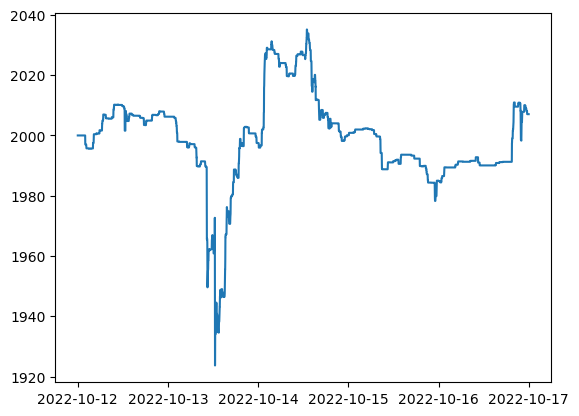

In [2]:

plotter(runner_instance.account_status_list)

In [3]:
account_status

AccountStatus(timestamp=None, base_balance=Decimal('0'), quote_balance=Decimal('0.1690551350801514176493073825'), uncollect_fee_base=Decimal('0E-35'), uncollect_fee_quote=Decimal('0.00003742511935923675690854665261'), base_in_position=Decimal('988.0519851946410168330389693'), quote_in_position=Decimal('0.6108350569460878802591830444'), net_value=Decimal('2007.064923914840597589349827'), price=Decimal('1306.548090256904049783161079'))

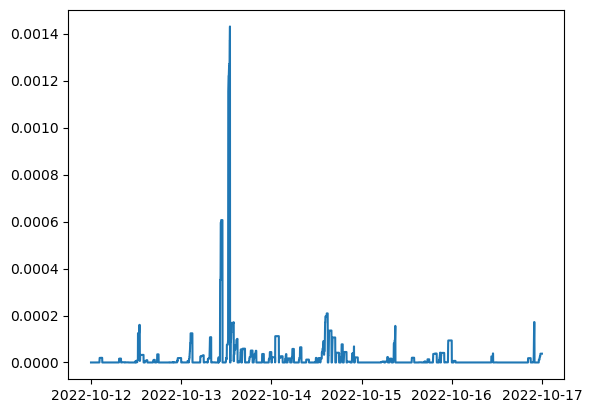

In [4]:
from typing import List
from matplotlib.pylab import plt
import matplotlib.dates as mdates

def plotter_fee(account_status_list:List[AccountStatus]):
    fee_ts = [status.uncollect_fee_quote for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, fee_ts)
    plt.show()

plotter_fee(runner_instance.account_status_list)

In [5]:
pd.options.plotting.backend = "plotly"

df = pd.DataFrame(runner_instance.account_status_list)

# df.set_index("timestamp", inplace=True)

# df['net_value'].plot()

In [6]:
df

,timestamp,base_balance,quote_balance,uncollect_fee_base,uncollect_fee_quote,base_in_position,quote_in_position,net_value,price
0,2022-10-12 00:01:00,2000usdc,0eth,0usdc,0eth,0usdc,0eth,2000usdc,1278.1193usdc/eth
1,2022-10-12 00:02:00,2000usdc,0eth,0usdc,0eth,0usdc,0eth,2000usdc,1278.1193usdc/eth
2,2022-10-12 00:03:00,2000usdc,0eth,0usdc,0eth,0usdc,0eth,2000usdc,1278.1193usdc/eth
3,2022-10-12 00:04:00,2000usdc,0eth,0usdc,0eth,0usdc,0eth,2000usdc,1278.1193usdc/eth
4,2022-10-12 00:05:00,2000usdc,0eth,0usdc,0eth,0usdc,0eth,2000usdc,1278.1193usdc/eth
...,...,...,...,...,...,...,...,...,...
7194,2022-10-16 23:55:00,0usdc,0.16905514eth,0usdc,0.000037425119eth,988.05199usdc,0.61083506eth,2007.0649usdc,1306.5481usdc/eth
7195,2022-10-16 23:56:00,0usdc,0.16905514eth,0usdc,0.000037425119eth,988.05199usdc,0.61083506eth,2007.0649usdc,1306.5481usdc/eth
7196,2022-10-16 23:57:00,0usdc,0.16905514eth,0usdc,0.000037425119eth,988.05199usdc,0.61083506eth,2007.0649usdc,1306.5481usdc/eth
7197,2022-10-16 23:58:00,0usdc,0.16905514eth,0usdc,0.000037425119eth,988.05199usdc,0.61083506eth,2007.0649usdc,1306.5481usdc/eth
